# Finetune with bedrock

Trying various models

In [52]:
import json
import os
import boto3
from dotenv import load_dotenv, find_dotenv
from datetime import datetime
import random

from huggingface_hub import login
from tokenizers import Tokenizer


In [91]:
#load globals
_ = load_dotenv(find_dotenv(), override=True) # read local .env file
HF_TOKEN=os.getenv('HF_TOKEN')
PROJECT_FOLDER='llama2-tuning-may-2024'
DATA_FOLDER='datasets'
login(HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/dpradilla/.cache/huggingface/token
Login successful


In [54]:
session = boto3.session.Session()
region = session.region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]
s3_suffix = f"{region}-{account_id}"
s3_client = boto3.client('s3')
bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")
iam = boto3.client('iam', region_name=region)
bedrock_bucket_name = f"bedrock-{region}-{account_id}"
print(session)
print(bedrock)
print(bedrock_bucket_name)

Session(region_name='us-east-1')
bedrock-us-east-1-510357808667


### Find out which models are available for fine tuning

In [69]:
for model in bedrock.list_foundation_models(byCustomizationType="FINE_TUNING")["modelSummaries"]:
    print (model["modelId"])

MODEL_ID="meta.llama2-13b-v1:0:4k"
HF_MODEL_ID="meta-llama/Llama-2-13b-chat-hf"

amazon.titan-image-generator-v1:0
amazon.titan-text-lite-v1:0:4k
amazon.titan-text-express-v1:0:8k
amazon.titan-embed-image-v1:0
cohere.command-text-v14:7:4k
cohere.command-light-text-v14:7:4k
meta.llama2-13b-v1:0:4k
meta.llama2-70b-v1:0:4k


### Create role and policies to run finetuning jobs in Bedrock

In [70]:
ROLE_DOC = f"""{{
    "Version": "2012-10-17",
    "Statement": [
        {{
            "Effect": "Allow",
            "Principal": {{
                "Service": "bedrock.amazonaws.com"
            }},
            "Action": "sts:AssumeRole",
            "Condition": {{
                "StringEquals": {{
                    "aws:SourceAccount": "{account_id}"
                }},
                "ArnEquals": {{
                    "aws:SourceArn": "arn:aws:bedrock:{region}:{account_id}:model-customization-job/*"
                }}
            }}
        }}
    ]
}}
"""
ACCESS_POLICY_DOC = f"""{{
    "Version": "2012-10-17",
    "Statement": [
        {{
            "Effect": "Allow",
            "Action": [
                "s3:AbortMultipartUpload",
                "s3:DeleteObject",
                "s3:PutObject",
                "s3:GetObject",
                "s3:GetBucketAcl",
                "s3:GetBucketNotification",
                "s3:ListBucket",
                "s3:PutBucketNotification"
            ],
            "Resource": [
                "arn:aws:s3:::{bedrock_bucket_name}",
                "arn:aws:s3:::{bedrock_bucket_name}/*"
            ]
        }}
    ]
}}"""

In [71]:
role_name=f"BedrockRole-{account_id}"
try:
    # Try to get the role if it exists
    response = iam.get_role(RoleName=role_name)
    print("Role already exists.")
except iam.exceptions.NoSuchEntityException:
    # If the role does not exist, create it
    print("Role does not exist. Creating role...")
    response = iam.create_role(
        RoleName=role_name,
        AssumeRolePolicyDocument=ROLE_DOC,
        Description="Role for Bedrock to access S3 for finetuning",
    )

# Print the role ARN
role_arn = response["Role"]["Arn"]
print(role_arn)

Role already exists.
arn:aws:iam::510357808667:role/BedrockRole-510357808667


In [72]:
policy_name=f"BedrockPolicy-{account_id}"

try:
    # Check if the policy exists and get its ARN
    paginator = iam.get_paginator('list_policies')
    policy_arn = None
    for response in paginator.paginate(Scope='Local'):
        found_policy = next((policy for policy in response['Policies'] if policy['PolicyName'] == policy_name), None)
        if found_policy:
            policy_arn = found_policy['Arn']
            print("Policy found with ARN:", policy_arn)
            break
    else:
        print("Policy not found. No need to detach or delete.")

    if policy_arn:
        # Detach policy from all entities
        paginator = iam.get_paginator('list_entities_for_policy')
        for response in paginator.paginate(PolicyArn=policy_arn):
            for role in response.get('PolicyRoles', []):
                iam.detach_role_policy(RoleName=role['RoleName'], PolicyArn=policy_arn)
                print(f"Detached from role: {role['RoleName']}")
            for user in response.get('PolicyUsers', []):
                iam.detach_user_policy(UserName=user['UserName'], PolicyArn=policy_arn)
                print(f"Detached from user: {user['UserName']}")
            for group in response.get('PolicyGroups', []):
                iam.detach_group_policy(GroupName=group['GroupName'], PolicyArn=policy_arn)
                print(f"Detached from group: {group['GroupName']}")

        # Delete the policy
        iam.delete_policy(PolicyArn=policy_arn)
        print("Policy deleted.")

    # Recreate the policy
    response = iam.create_policy(
        PolicyName=policy_name,
        PolicyDocument=ACCESS_POLICY_DOC,
    )
    policy_arn = response['Policy']['Arn']
    print("Policy recreated with ARN:", policy_arn)

except Exception as e:
    print(f"An error occurred: {e}")

Policy found with ARN: arn:aws:iam::510357808667:policy/BedrockPolicy-510357808667
Detached from role: BedrockRole-510357808667
Policy deleted.
Policy recreated with ARN: arn:aws:iam::510357808667:policy/BedrockPolicy-510357808667


In [73]:
iam.attach_role_policy(
    RoleName=role_name,
    PolicyArn=policy_arn,
)

{'ResponseMetadata': {'RequestId': 'e3dc0d76-9e3e-4934-9cb9-b4d1417761c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 08 May 2024 21:09:11 GMT',
   'x-amzn-requestid': 'e3dc0d76-9e3e-4934-9cb9-b4d1417761c9',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [74]:
tokenizer = Tokenizer.from_pretrained(HF_MODEL_ID)
tokenizer.decode(tokenizer.encode("hola como estas").ids[:3])


'hola'

### Prepare and upload the data

Data format reference: https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-prepare.html

In [75]:
#truncate the training and validation files to fit in the training window

MAX_CHARACTERS = 24400
MAX_TOKENS = 4000
tokenizer = Tokenizer.from_pretrained(HF_MODEL_ID)

for filename in os.listdir("data"):
    if filename.endswith('.jsonl'):
        file_path = os.path.join("data", filename)
        # Read all the data from the file
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        # Truncate completions and write back to the file
        with open(file_path, 'w', encoding='utf-8') as file:
            for line in lines:
                data = json.loads(line)
                # Truncate the 'completion' field if it's too long
                input_tokens = tokenizer.encode(data['prompt'])
                output_tokens = tokenizer.encode(data['completion'])
                if (len(input_tokens)+len(output_tokens))>MAX_TOKENS:
                    print(f'too long! output_tokens:{len(output_tokens)}')
                    max_output_length = MAX_TOKENS - len(input_tokens)
                    data['completion'] = tokenizer.decode(output_tokens.ids[:max_output_length])
                # Write the updated JSON line back to the file
                json.dump(data, file, ensure_ascii=False)
                file.write('\n')  # Ensure each record is on a new line


In [76]:
s3_client.upload_file(f'data/tuning_entries_training.jsonl', bedrock_bucket_name, f"{PROJECT_FOLDER}/train/train.jsonl")
s3_client.upload_file(f'data/tuning_entries_validation.jsonl', bedrock_bucket_name, f"{PROJECT_FOLDER}/validation/validation.jsonl")

s3_train_uri=f's3://{bedrock_bucket_name}/{PROJECT_FOLDER}/train/train.jsonl'
s3_validation_uri=f's3://{bedrock_bucket_name}/{PROJECT_FOLDER}/validation/validation.jsonl'

#folder to store tuning output results
s3_client.put_object(Bucket=bedrock_bucket_name, Key="{PROJECT_FOLDER}/model-output/")
s3_output_uri=f's3://{bedrock_bucket_name}/{PROJECT_FOLDER}/model-output/'




## Training

In [78]:
model_name = MODEL_ID.replace('-', '').replace(':', '').replace('.', '') +'-'+''.join(random.choices('0123456789ABCDEF', k=5))
print(f"Model Name: {model_name}")
# Current timestamp
job_name = f"{model_name}-{datetime.now().strftime('%Y%m%d%H%M%S')}"
print(f"Job Name: {job_name}")

hyper_parameters = {
        "epochCount": "2",
        "batchSize": "1",
        "learningRate": "0.00001",
    }

bedrock.create_model_customization_job(
    customizationType="FINE_TUNING",
    jobName=job_name,
    customModelName=model_name,
    roleArn=role_arn,
    baseModelIdentifier=MODEL_ID,
    hyperParameters = hyper_parameters,
    trainingDataConfig={"s3Uri": s3_train_uri},
    validationDataConfig={"validators": [{"s3Uri": s3_validation_uri}]},
    outputDataConfig={"s3Uri": s3_output_uri},
)

Model Name: metallama270bv104k-83DF7
Job Name: metallama270bv104k-83DF7-20240508230936


{'ResponseMetadata': {'RequestId': '88f182c7-21c9-4af2-a8db-1ed963701dfa',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Wed, 08 May 2024 21:09:36 GMT',
   'content-type': 'application/json',
   'content-length': '112',
   'connection': 'keep-alive',
   'x-amzn-requestid': '88f182c7-21c9-4af2-a8db-1ed963701dfa'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:510357808667:model-customization-job/meta.llama2-70b-v1:0:4k/uwgqju0q1yzp'}

In [79]:
import time
fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=job_name)["status"]
print(fine_tune_job)

while fine_tune_job == "InProgress":
    time.sleep(60)
    fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=job_name)["status"]
    print (fine_tune_job)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


## Get custom models

In [ ]:
bedrock.list_custom_models()


{'ResponseMetadata': {'RequestId': 'edfe5467-95e5-4ab6-b2ff-c8e9dd8d123d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 10 May 2024 12:59:10 GMT',
   'content-type': 'application/json',
   'content-length': '1000',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'edfe5467-95e5-4ab6-b2ff-c8e9dd8d123d'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1:510357808667:custom-model/meta.llama2-70b-v1:0:4k/q8tm67wt6tar',
   'modelName': 'metallama270bv104k-83DF7',
   'creationTime': datetime.datetime(2024, 5, 8, 21, 9, 36, 491000, tzinfo=tzutc()),
   'baseModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/meta.llama2-70b-v1:0:4k',
   'baseModelName': '',
   'customizationType': 'FINE_TUNING'},
  {'modelArn': 'arn:aws:bedrock:us-east-1:510357808667:custom-model/meta.llama2-13b-v1:0:4k/8r3vbau5chez',
   'modelName': 'metallama213bv104k-E3F44',
   'creationTime': datetime.datetime(2024, 5, 8, 12, 55, 49, 269000, tzinfo=tzutc()),
   'baseMo

In [130]:
# retrieve the modelArn of the fine-tuned model
selected_model = 'metallama213bv104k-E3F44'
fine_tune_job = bedrock.get_custom_model(modelIdentifier=selected_model)
custom_model_id = fine_tune_job['modelArn']
print(f"custom model arn: {custom_model_id}")
output_job_name = "model-customization-job-"+fine_tune_job['jobArn'].split('/')[-1]
print(f"custom model job name: {output_job_name}")

custom model arn: arn:aws:bedrock:us-east-1:510357808667:custom-model/meta.llama2-13b-v1:0:4k/8r3vbau5chez
custom model job name: model-customization-job-g86picqn6m75


## Visualize results

In [112]:
output_metrics_path = f"data/output/{PROJECT_FOLDER}/{output_job_name}"
os.makedirs(output_metrics_path, exist_ok=True)


In [113]:
train_metrics_s3_prefix=f"{PROJECT_FOLDER}/model-output/{output_job_name}/training_artifacts/step_wise_training_metrics.csv"
validation_metrics_s3_prefix=f"{PROJECT_FOLDER}/model-output/{output_job_name}/validation_artifacts/post_fine_tuning_validation/validation/validation_metrics.csv"
train_metrics_name='train_metrics.csv'
validation_metrics_name='validation_metrics.csv'
train_file_name_local=output_metrics_path+'/'+train_metrics_name
validation_file_name_local=output_metrics_path+'/'+validation_metrics_name
print(train_metrics_s3_prefix)
s3_client.download_file(bedrock_bucket_name, train_metrics_s3_prefix, train_file_name_local)
s3_client.download_file(bedrock_bucket_name, validation_metrics_s3_prefix, validation_file_name_local)

llama2-tuning-may-2024/model-output/model-customization-job-uwgqju0q1yzp/training_artifacts/step_wise_training_metrics.csv


In [114]:
import pandas as pd
from matplotlib import pyplot as plt

train_data = pd.read_csv(train_file_name_local)
train_metrics_epoch=train_data.groupby('epoch_number').mean()
validation_metrics_epoch=pd.read_csv(validation_file_name_local)

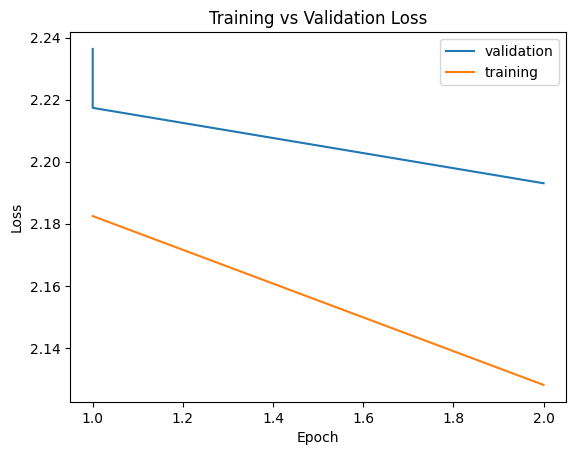

In [115]:
plt.plot(validation_metrics_epoch.epoch_number, validation_metrics_epoch.validation_loss,label='validation')
plt.plot(train_metrics_epoch.index, train_metrics_epoch.training_loss,label='training')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Provision model

In [131]:
# Create the provision throughput job and retrieve the provisioned model id
print(f"custom model arn: {custom_model_id}")
provisioned_model_id = bedrock.create_provisioned_model_throughput(
     modelUnits=1,
    # create a name for your provisioned throughput model
     provisionedModelName=f'test-{selected_model}', 
     modelId=custom_model_id
    )['provisionedModelArn']  
print(provisioned_model_id)

custom model arn: arn:aws:bedrock:us-east-1:510357808667:custom-model/meta.llama2-13b-v1:0:4k/8r3vbau5chez


In [132]:
%%timeit
# check provisioned throughput job status
import time
status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId = provisioned_model_id)['status'] 
while status_provisioning == 'Creating':
    time.sleep(60)
    status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId=provisioned_model_id)['status']
    print(status_provisioning)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
299 ms ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Prompt provisioned model

In [133]:
def prompt_model(provisioned_model_id, prompt):
    body = json.dumps({
        "prompt": prompt,
        # specify the parameters as needed
        "max_gen_len": 200,
        "temperature": 0.4,
        "top_p": 0.3,
    })

    response = bedrock_runtime.invoke_model(body=body, modelId=provisioned_model_id, accept='application/json', contentType='application/json')
    response_body = json.loads(response.get('body').read())
    print(response_body)

In [140]:
prompt = "Escribe una entrada corta de diario por ROBELLO CHEBELO MAMELO cuando tenía 25 años"
prompt_model(provisioned_model_id, prompt)

{'generation': '.\nROBELLO CHEBELO MAMELO\n1990-01-01 00:00:00\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', 'prompt_token_count': 30, 'generation_token_count': 200, 'stop_reason': 'length'}


### Clean up

In [141]:
# delete the provisioned throughput
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)

{'ResponseMetadata': {'RequestId': '92052355-459b-44e4-bfb9-a7f8a97c02bf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 13 May 2024 11:51:44 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '92052355-459b-44e4-bfb9-a7f8a97c02bf'},
  'RetryAttempts': 0}}